#####  To describe the laboratory characteristics of patients in relation to their coronary calcification score, using a regression approach. 

#####  1. Importing dependencies 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

##### 2. Reading dataset and pre processing

In [127]:
df = pd.read_excel(r"C:\Users\lavan\Downloads\RA_NUIG\CALCIUM ZERO DATASET 25 July .xlsx", na_values=["", " ", "NA", "N/A"])

#columns hidden on the excel sheet were said to be irrelvant so they were removed
dropcolumns = ["height","weight", "record","reason___3",
               "reason___4",
               "reason___5",
               "other_symptoms",
               "bp",
               "systolic_blood_pressure",
               "diastoic_blood_pressure",
               "hr",
               "country",             "mother", 
               "father",
               "language",
               "glucose",
               "random",
               "lip_a_nmol_l", 
               "lipoprotein_a_mg_dl", 
               "laboratory_data_complete",
               "ct___1",
               "ct___2",
               "contrast",
               "contrast_amount",
               "radiation",
               "calcification_score",
               "percentile_rank",
               "plaque_burden",
               "clinical_impression",
               "ct_coronary_angiography_complete",
               "Unnamed: 74",
               "Unnamed: 75",
               "Presence of any plaque (yes=1; no=0)",
               "Patients with ZERO CALCIUM SCORE (yes=1; no=0)",
               "CADrads_classification",
               "type", "ast" , "ethnicity", "calcium",
                 "type","potassium" #removed since they have 15% missing values
              ]
df = df.drop(columns=dropcolumns)
print(df.shape)

(794, 38)


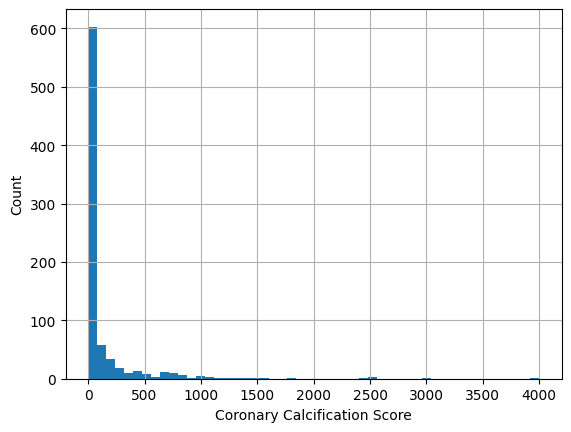

min       0.0
max    4000.0
Name: coronary_calcification_score, dtype: float64


In [128]:
# check score distribution
df["coronary_calcification_score"].hist(bins=50)
plt.xlabel("Coronary Calcification Score")
plt.ylabel("Count")
plt.show()
print(df["coronary_calcification_score"].describe()[["min", "max"]])

In [129]:
print("Median:", np.median(df["coronary_calcification_score"]))
print("Mean:", np.mean(df["coronary_calcification_score"]))
print("95th percentile:", np.percentile(df["coronary_calcification_score"], 95))
print("99th percentile:", np.percentile(df["coronary_calcification_score"], 99))
print("Max:", np.max(df["coronary_calcification_score"]))


Median: 1.0
Mean: 118.39735516372797
95th percentile: 686.3499999999999
99th percentile: 1483.6199999999958
Max: 4000.0


In [130]:
p99 = np.percentile(y_raw, 99)
idx_out = np.where(y_raw > p99)[0]
print(f"99th pct: {p99:.1f} | n_outliers: {len(idx_out)}")
print("Top outliers (value, index):", sorted([(y_raw[i], i) for i in idx_out], reverse=True)[:10])


99th pct: 1828.4 | n_outliers: 5
Top outliers (value, index): [(np.float64(4000.0), np.int64(395)), (np.float64(2986.0), np.int64(266)), (np.float64(2500.0), np.int64(352)), (np.float64(2500.0), np.int64(338)), (np.float64(2438.0), np.int64(252))]


### CC score appears to be highly right skewed and has multiple outliers.  

In [131]:
missing_counts = df.isnull().sum()
missing_perc = (df.isnull().mean() * 100).round(2) # %

missing_table = pd.DataFrame({
    #"Variable" : df.columns,
    "Missing Count": missing_counts,
    "Missing Percent": missing_perc
})
print(missing_table.sort_values("Missing Count", ascending=False).head(46))  



                              Missing Count  Missing Percent
ck                                      102            12.85
alt                                      94            11.84
stroke                                   75             9.45
ggt                                      67             8.44
apoa                                     48             6.05
ratio                                    48             6.05
bilirubin                                48             6.05
apob                                     48             6.05
lipoprotein_a                            42             5.29
troponin                                 41             5.16
ldl                                      35             4.41
cad                                      32             4.03
pad                                      31             3.90
adjusted_calcium                         27             3.40
crp                                      26             3.27
egfr                    

In [132]:
df_complete = df.dropna()
print("Original shape:", df.shape)
print("Reduced shape after dropping rows:", df_complete.shape)
# numeric column
zero_count = df_complete["coronary_calcification_score"].eq(0).sum()
print("Zero count for CC score:", zero_count)
df_complete = df_complete.copy()

df_complete["smoking"] = df_complete["smoking"].astype("category")


Original shape: (794, 38)
Reduced shape after dropping rows: (499, 38)
Zero count for CC score: 254


### Linear regression

In [133]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [134]:
TARGET="coronary_calcification_score"

y = np.log1p(df_complete["coronary_calcification_score"])     
X = df_complete.drop(columns=["coronary_calcification_score"])

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

pipe_lr = make_pipeline(StandardScaler(), LinearRegression())
pipe_lr.fit(X_tr, y_tr)

y_pred_log = pipe_lr.predict(X_te)
y_pred = np.expm1(y_pred_log)   # back-transform
y_true = np.expm1(y_te)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2 : {r2:.3f}")


# Smearing factor from train residuals
res_tr = y_tr - pipe_lr.predict(X_tr)
smear = np.mean(np.exp(res_tr))

y_pred_log = pipe_lr.predict(X_te)
y_pred1 = smear * np.expm1(y_pred_log)
y_true = np.expm1(y_te)

rmse1 = mean_squared_error(y_true, y_pred1)
rmse_s= np.sqrt(rmse1)
mae1  = mean_absolute_error(y_true, y_pred1)
print("After the smearing:")
print(f"RMSE : {rmse_s:.2f}")
print( f"MAE: {mae1:.2f}")
r2 = r2_score(y_true, y_pred1) 
print(f"R^2: {r2:.2f}")

MAE : 131.15
RMSE: 433.07
R^2 : -0.030
After the smearing:
RMSE : 391.07
MAE: 150.33
R^2: 0.16


##### Smearing improved overall fit (positive R²), but predictive power is still weak.

#### Regularized linear model (ElasticNetCV)

In [135]:
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder ,  StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNetCV


In [136]:
cat_cols = ["smoking"] 
num_cols = [c for c in df_complete.columns if c not in ["smoking", "coronary_calcification_score"]]


# One-hot encoder
ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False) # only used for smoking variable since it has 3 categories

# Column transformer
pre = ColumnTransformer(
    [("num", StandardScaler(), num_cols),
     ("cat", ohe, cat_cols)],
    remainder="drop"
)

In [137]:

enet = ElasticNetCV(
    alphas=200,                  
    l1_ratio=[0.1,0.3,0.5,0.7,0.9,1.0],
    cv=5, random_state=42
)
pipe = make_pipeline(pre, enet)

pipe.fit(X_tr, y_tr)

y_pred_log = pipe.predict(X_te)

best_enet = pipe.named_steps["elasticnetcv"]
print("Best alpha   :", best_enet.alpha_)
print("Best l1_ratio:", best_enet.l1_ratio_)

Best alpha   : 0.2512560240423698
Best l1_ratio: 0.1


In [138]:
#y_pred_log = pipe.predict(X_te) # pred
y_pred = np.expm1(y_pred_log)    # back to original scale
y_true = np.expm1(y_te)   # back-transformation

mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)                
r2   = r2_score(y_true, y_pred)

print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2 : {r2:.3f}")

MAE : 131.52
RMSE: 435.75
R^2 : -0.042


####  Two-part model (Part I: logistic Part II: log-normal + Duan smearing) 
1. **Logistic regression (Part I):**  
   - Train/test split with stratification on nonzero values.  
   - Logistic regression predicts probability that the score > 0.  

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.base import clone
import statsmodels.formula.api as smf


In [140]:

    
TARGET = "coronary_calcification_score"

y_raw = df_complete[TARGET].values
X_all = df_complete.drop(columns=[TARGET])
strat = (y_raw > 0).astype(int)

X_tr_raw, X_te_raw, y_tr_raw, y_te_raw = train_test_split(
    X_all, y_raw, test_size=0.20, random_state=42, stratify=strat
)

# Part 1: Logistic 
clf = Pipeline([("pre", clone(pre)), ("lg", LogisticRegression(max_iter=2000))])
clf.fit(X_tr_raw, (y_tr_raw > 0).astype(int))
p_hat_te = clf.predict_proba(X_te_raw)[:, 1]

print(f"Classifier AUC: {roc_auc_score((y_te_raw>0).astype(int), p_hat_te):.3f} | "
      f"PR-AUC: {average_precision_score((y_te_raw>0).astype(int), p_hat_te):.3f}")

num_sel = X_tr_raw.select_dtypes(include=[np.number]).columns.tolist()
cat_sel = [c for c in X_tr_raw.columns if c not in num_sel]

for c in ["smoking"]: 
    if c in X_tr_raw.columns and c in num_sel:
        num_sel.remove(c)
        cat_sel.append(c)

cols_part2 = num_sel + cat_sel

Classifier AUC: 0.621 | PR-AUC: 0.653




2. **Log-normal model with Duan smearing (Part II):**  
   - Subset data to positive scores.  
   - Standardize numerical variables and convert categorical predictors into factors.  
   - Fit OLS on `log(y)` to account for skewness.  
   - Apply Duan smearing factor to back-transform variables to the original scale

In [141]:
#Modelling
pos_mask = y_tr_raw > 0
X_pos = X_tr_raw.loc[pos_mask, cols_part2].copy()
y_pos = y_tr_raw[pos_mask].copy()

# Standarizing numerical variables :z-score
num_stats = {c: (float(X_pos[c].mean()), float(X_pos[c].std() or 1.0)) for c in num_sel}
X_design = X_pos.copy()
for c, (mu, sd) in num_stats.items():
    X_design[c] = (X_design[c] - mu) / sd

#formula: numeric + categorical as factors
rhs_terms = []
if num_sel: rhs_terms += num_sel
if cat_sel: rhs_terms += [f"C({c})" for c in cat_sel]
formula = f"logy ~ {' + '.join(rhs_terms) if rhs_terms else '1'}"
print("\nPart II (log-normal) formula:\n", formula)

# Fit OLS on log(y) and compute Duan smearing
ols = smf.ols(formula, data=X_design.assign(logy=np.log(y_pos))).fit()
smear = float(np.exp(ols.resid).mean())


Part II (log-normal) formula:
 logy ~ bmi_cal + age + gender + alcohol + hypertension + hyperlipidemia + diabetes + family + atherosclerosis + pad + cad + stroke + troponin + ck + hb + wbc + plt + tc + tg + hdl + ldl + hba1c + crp + egfr + creatinine + bun + sodium + lipoprotein_a + apoa + apob + ratio + bilirubin + alt + ggt + chloride + adjusted_calcium + C(smoking)


In [142]:
# Predict μ+ on TEST
X_te_glm = X_te_raw[cols_part2].copy()
for c, (mu, sd) in num_stats.items():
    X_te_glm[c] = (X_te_glm[c] - mu) / sd

mu_plus_te = np.exp(ols.predict(X_te_glm)) * smear              # E[Y | Y>0, X]
y_hat_te   = np.clip(p_hat_te * mu_plus_te, 0, None)            # Overall E[Y | X]

# Metrics
rmse = lambda a,b: float(np.sqrt(mean_squared_error(a,b)))
pos_te = y_te_raw > 0

print("PART II (Y>0, test) — MAE/RMSE/R²:",
      f"{mean_absolute_error(y_te_raw[pos_te], mu_plus_te[pos_te]):.3f}",
      f"{rmse(y_te_raw[pos_te], mu_plus_te[pos_te]):.3f}",
      f"{r2_score(y_te_raw[pos_te], mu_plus_te[pos_te]):.3f}")

print("OVERALL (2-part) — MAE/RMSE/R²:",
      f"{mean_absolute_error(y_te_raw, y_hat_te):.3f}",
      f"{rmse(y_te_raw, y_hat_te):.3f}",
      f"{r2_score(y_te_raw, y_hat_te):.3f}")


PART II (Y>0, test) — MAE/RMSE/R²: 232.497 437.420 0.534
OVERALL (2-part) — MAE/RMSE/R²: 151.892 341.685 0.468


### Two-Part Model Performance – Coronary Calcification (CAC)

**Part II (Y>0):** MAE 232.6 | RMSE 438.3 | R² 0.53  
→ Explains ~53% of variability; some large errors due to extreme CAC values.  

**Overall (Two-Part):** MAE 152.5 | RMSE 342.4 | R² 0.47  
→ Captures ~47% of total variability; zeros improve fit.  

**Summary:** Two-part model performs reasonably well; main limitation is extreme values.


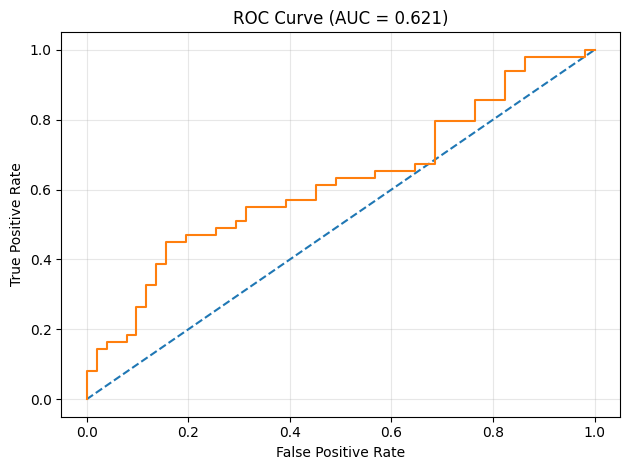

In [143]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
)
from sklearn.calibration import calibration_curve

y_te_bin = (y_te_raw > 0).astype(int)

# Roc
fpr, tpr, _ = roc_curve(y_te_bin, p_hat_te)
auc = roc_auc_score(y_te_bin, p_hat_te)

plt.figure()
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(fpr, tpr, marker=None)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {auc:.3f})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

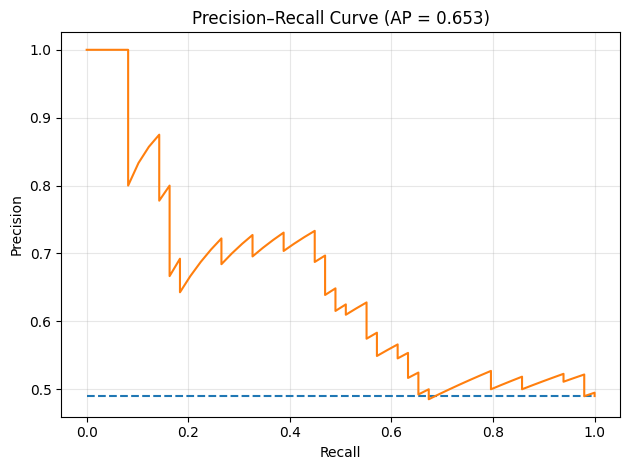

In [144]:
# Precision–Recall 
prec, rec, _ = precision_recall_curve(y_te_bin, p_hat_te)
ap = average_precision_score(y_te_bin, p_hat_te)
baseline = y_te_bin.mean()

plt.figure()
plt.plot([0, 1], [baseline, baseline], linestyle="--")
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {ap:.3f})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

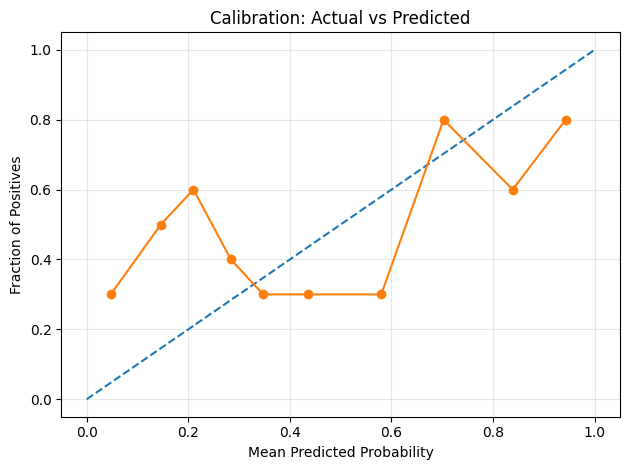

In [145]:
#  Actual vs Predicted 

frac_pos, mean_pred = calibration_curve(y_te_bin, p_hat_te, n_bins=10, strategy="quantile")

plt.figure()
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(mean_pred, frac_pos, marker="o")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration: Actual vs Predicted")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### K-fold validation

In [146]:
from sklearn.model_selection import StratifiedKFold

def rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

# stratify by zero vs >0
z = (y_raw > 0).astype(int)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

maes_over, rmses_over, r2s_over = [], [], []
maes_pos, rmses_pos, r2s_pos = [], [], []

for fold, (tr, te) in enumerate(skf.split(X_all, z), 1):
    X_tr_raw, X_te_raw = X_all.iloc[tr].copy(), X_all.iloc[te].copy()
    y_tr_raw, y_te_raw = y_raw[tr], y_raw[te]

    #Part I: logistic
    clf = Pipeline([("pre", clone(pre)), ("lg", LogisticRegression(max_iter=2000))])
    clf.fit(X_tr_raw, (y_tr_raw > 0).astype(int))
    p_hat_te = clf.predict_proba(X_te_raw)[:, 1]

    # Part II: log-normal OLS on train positives 
    num_sel = X_tr_raw.select_dtypes(include=[np.number]).columns.tolist()
    cat_sel = [c for c in X_tr_raw.columns if c not in num_sel]
    for c in ["smoking"]:
        if c in X_tr_raw.columns and c in num_sel:
            num_sel.remove(c)
            cat_sel.append(c)
    cols_part2 = num_sel + cat_sel

    pos_mask = y_tr_raw > 0
    X_pos = X_tr_raw.loc[pos_mask, cols_part2].copy()
    y_pos = y_tr_raw[pos_mask].copy()

    num_stats = {c: (float(X_pos[c].mean()), float(X_pos[c].std() or 1.0)) for c in num_sel}
    X_design = X_pos.copy()
    for c, (mu, sd) in num_stats.items():
        X_design[c] = (X_design[c] - mu) / sd

    rhs_terms = []
    if num_sel: rhs_terms += num_sel
    if cat_sel: rhs_terms += [f"C({c})" for c in cat_sel]
    formula = f"logy ~ {' + '.join(rhs_terms) if rhs_terms else '1'}"

    ols = smf.ols(formula, data=X_design.assign(logy=np.log(y_pos))).fit()
    smear = float(np.exp(ols.resid).mean())

    X_te_glm = X_te_raw[cols_part2].copy()
    for c, (mu, sd) in num_stats.items():
        X_te_glm[c] = (X_te_glm[c] - mu) / sd

    mu_plus_te = np.exp(ols.predict(X_te_glm)) * smear
    y_hat_te   = np.clip(p_hat_te * mu_plus_te, 0, None)

    
    pos_te = y_te_raw > 0
    mae_pos  = mean_absolute_error(y_te_raw[pos_te], mu_plus_te[pos_te])
    rm_pos   = rmse(y_te_raw[pos_te], mu_plus_te[pos_te])
    r2_pos   = r2_score(y_te_raw[pos_te], mu_plus_te[pos_te])

    mae_over = mean_absolute_error(y_te_raw, y_hat_te)
    rm_over  = rmse(y_te_raw, y_hat_te)
    r2_over  = r2_score(y_te_raw, y_hat_te)

    maes_pos.append(mae_pos); rmses_pos.append(rm_pos); r2s_pos.append(r2_pos)
    maes_over.append(mae_over); rmses_over.append(rm_over); r2s_over.append(r2_over)

    print(f"Fold {fold} — PART II (Y>0): MAE {mae_pos:.2f} | RMSE {rm_pos:.2f} | R² {r2_pos:.3f} "
          f"|| OVERALL: MAE {mae_over:.2f} | RMSE {rm_over:.2f} | R² {r2_over:.3f}")

print("\n 5-Fold CV Summary ")
print(f"Positives : MAE {np.mean(maes_pos):.2f}±{np.std(maes_pos):.2f} | "
      f"RMSE {np.mean(rmses_pos):.2f}±{np.std(rmses_pos):.2f} | "
      f"R² {np.mean(r2s_pos):.3f}±{np.std(r2s_pos):.3f}")

print(f"Overall: MAE {np.mean(maes_over):.2f}±{np.std(maes_over):.2f} | "
      f"RMSE {np.mean(rmses_over):.2f}±{np.std(rmses_over):.2f} | "
      f"R² {np.mean(r2s_over):.3f}±{np.std(r2s_over):.3f}")


Fold 1 — PART II (Y>0): MAE 304.59 | RMSE 565.48 | R² -0.422 || OVERALL: MAE 313.14 | RMSE 1576.65 | R² -19.089
Fold 2 — PART II (Y>0): MAE 780.48 | RMSE 3321.69 | R² -54.826 || OVERALL: MAE 387.38 | RMSE 1989.11 | R² -34.227
Fold 3 — PART II (Y>0): MAE 217972.54 | RMSE 1519494.08 | R² -24207408.458 || OVERALL: MAE 106664.56 | RMSE 1063642.69 | R² -18599771.462
Fold 4 — PART II (Y>0): MAE 226.95 | RMSE 394.19 | R² 0.434 || OVERALL: MAE 122.54 | RMSE 285.37 | R² 0.455
Fold 5 — PART II (Y>0): MAE 548.56 | RMSE 1704.84 | R² -6.149 || OVERALL: MAE 281.43 | RMSE 1147.20 | R² -5.036

 5-Fold CV Summary 
Positives : MAE 43966.62±87003.18 | RMSE 305096.06±607199.91 | R² -4841493.884±9682957.287
Overall: MAE 21553.81±42555.46 | RMSE 213728.20±424957.62 | R² -3719965.872±7439902.795


### Cubic splines + Ridge on log1p(y) 

In [ ]:
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import RidgeCV

In [54]:
num_cols_in = [c for c in num_sel if c in X_tr_raw.columns]
cat_cols_in = [c for c in cat_sel if c in X_tr_raw.columns]

# splines for numerics + One HotEncoding for categoricals
num_pipe = Pipeline([
    ("spline", SplineTransformer(degree=3, n_knots=7, knots="quantile", include_bias=False)),
    ("sc", StandardScaler()),
])

pre_spline = ColumnTransformer(
    [("num", num_pipe, num_cols_in)] +
    ([("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols_in)] if len(cat_cols_in) else []),
    remainder="drop"
)

In [ ]:
# Model: Ridge with CV on alphas
model_spline = Pipeline([
    ("pre", pre_spline),
    ("ridge", RidgeCV(alphas=np.logspace(-4, 3, 20), fit_intercept=True))
])

# Train on 'Training set with log1p transform
y_tr_log1p = np.log1p(np.clip(y_tr_raw, 0, None))
model_spline.fit(X_tr_raw[num_cols_in + cat_cols_in], y_tr_log1p)

# Duan smearing on  residuals
eta_tr = model_spline.predict(X_tr_raw[num_cols_in + cat_cols_in])
res_tr = y_tr_log1p - eta_tr
smear = float(np.mean(np.exp(res_tr)))

In [56]:
# Predict on TEST and invert transform with smearing
eta_te   = model_spline.predict(X_te_raw[num_cols_in + cat_cols_in])
y_hat_te = np.clip(np.exp(eta_te) * smear - 1.0, 0, None)

# Metrics
rmse = lambda a,b: float(np.sqrt(mean_squared_error(a,b)))
print("Splines+Ridge (single-stage) — MAE/RMSE/R²:",
      f"{mean_absolute_error(y_te_raw, y_hat_te):.3f}",
      f"{rmse(y_te_raw, y_hat_te):.3f}",
      f"{r2_score(y_te_raw, y_hat_te):.3f}")


Splines+Ridge (single-stage) — MAE/RMSE/R²: 132.612 390.535 0.306


### Single-stage GAM on log1p(y) with splines + smoking factor + te(interactions) 

In [25]:
from pygam import LinearGAM, s, f, te

In [26]:
num_cols_in = [c for c in num_sel if c in X_tr_raw.columns]
use_smoking = ("smoking" in cat_sel) and ("smoking" in X_tr_raw.columns)

# build GAM design: numerics and categorical ( smoking) as the last column
Xtr_num = X_tr_raw[num_cols_in].to_numpy() #train
Xte_num = X_te_raw[num_cols_in].to_numpy() #test

if "smoking" in X_tr_raw.columns:
    # one-hot encode 3 levels: 1=yes, 2=no, 3=ex-smoker
    sm_tr = pd.get_dummies(X_tr_raw["smoking"], prefix="smoke", drop_first=True)
    sm_te = pd.get_dummies(X_te_raw["smoking"], prefix="smoke", drop_first=True)

    # align columns between train and test
    sm_te = sm_te.reindex(columns=sm_tr.columns, fill_value=0)

    # add to numeric design
    Xtr_gam = np.c_[Xtr_num, sm_tr.to_numpy()]
    Xte_gam = np.c_[Xte_num, sm_te.to_numpy()]
else:
    Xtr_gam, Xte_gam = Xtr_num, Xte_num

y_tr_log1p = np.log1p(np.clip(y_tr_raw, 0, None))

In [ ]:
p = Xtr_num.shape[1]                 # numeric features count
terms = None
for i in range(p):
    terms = s(i, n_splines=8) if terms is None else terms + s(i, n_splines=8)

if use_smoking:
    sm_idx = p                       # smoking column index at the end
    terms = terms + f(sm_idx)        # factor term for smoking
    for i in range(p):
        terms = terms + te(i, sm_idx, n_splines=6)  # spline×smoking interaction

gam = LinearGAM(terms)
gam.gridsearch(Xtr_gam, y_tr_log1p, lam=np.logspace(-4, 4, 12))

# Duan smearing on log1p residuals
eta_tr = gam.predict(Xtr_gam)
smear  = float(np.mean(np.exp(y_tr_log1p - eta_tr)))

  0% (0 of 12) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  8% (1 of 12) |##                       | Elapsed Time: 0:00:03 ETA:   0:00:42
 16% (2 of 12) |####                     | Elapsed Time: 0:00:07 ETA:   0:00:38
 25% (3 of 12) |######                   | Elapsed Time: 0:00:11 ETA:   0:00:33
 33% (4 of 12) |########                 | Elapsed Time: 0:00:14 ETA:   0:00:29
 41% (5 of 12) |##########               | Elapsed Time: 0:00:18 ETA:   0:00:26
 50% (6 of 12) |############             | Elapsed Time: 0:00:22 ETA:   0:00:22
 58% (7 of 12) |##############           | Elapsed Time: 0:00:26 ETA:   0:00:18
 66% (8 of 12) |################         | Elapsed Time: 0:00:30 ETA:   0:00:15
 75% (9 of 12) |##################       | Elapsed Time: 0:00:33 ETA:   0:00:11
 83% (10 of 12) |####################    | Elapsed Time: 0:00:37 ETA:   0:00:07
 91% (11 of 12) |######################  | Elapsed Time: 0:00:41 ETA:   0:00:03
100% (12 of 12) |#######################

In [28]:
# Predict and invert transform
eta_te   = gam.predict(Xte_gam)
y_hat_te = np.clip(np.exp(eta_te) * smear - 1.0, 0, None)

# Metrics
rmse = lambda a,b: float(np.sqrt(mean_squared_error(a,b)))
print("GAM splines (single-stage) — MAE/RMSE/R²:",
      f"{mean_absolute_error(y_te_raw, y_hat_te):.3f}",
      f"{rmse(y_te_raw, y_hat_te):.3f}",
      f"{r2_score(y_te_raw, y_hat_te):.3f}")


GAM splines (single-stage) — MAE/RMSE/R²: 135.515 395.358 0.288


### HURDLE MODEL with CatBoost: (Classifier P[y>0]) x (Regressor on log1p(y | y>0)) 

In [29]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

In [30]:
def rmsle(y_true, y_pred, eps=1e-9): #RMSE
    yt = np.clip(y_true, 0, None)
    yp = np.clip(y_pred, 0, None)
    return float(np.sqrt(np.mean((np.log1p(yp+eps) - np.log1p(yt+eps))**2)))

def get_cat_indices(df: pd.DataFrame): #Caetgorical columns for CatBoost
    cats = [c for c in df.columns if str(df[c].dtype) in ("category", "object", "bool")]
    return [df.columns.get_loc(c) for c in cats]

def make_pool(X, y=None, cat_idx=None):
    if cat_idx is None: cat_idx = []
    return Pool(X, label=y, cat_features=cat_idx) if y is not None else Pool(X, cat_features=cat_idx)


In [ ]:
y_tr = y_tr_raw.copy()
y_te = y_te_raw.copy()

y_tr_bin = (y_tr > 0).astype(int)
y_te_bin = (y_te > 0).astype(int)

X_tr_raw["smoking"] = X_tr_raw["smoking"].astype("string")
X_te_raw["smoking"] = X_te_raw["smoking"].astype("string")
cat_features = ["smoking"]   # CatBoost will handle this as categorical

#  CatBoost Pools
train_pool_cls = Pool(X_tr_raw, label=y_tr_bin, cat_features=cat_features)
valid_pool_cls = Pool(X_te_raw,  label=y_te_bin,  cat_features=cat_features)
test_pool      = Pool(X_te_raw,  cat_features=cat_features)

In [ ]:

pos_rate = y_tr_bin.mean()
w_neg = 0.5 / (1 - pos_rate + 1e-9)
w_pos = 0.5 / (pos_rate + 1e-9)
class_weights = [w_neg, w_pos]

clf = CatBoostClassifier(
    loss_function="Logloss",         # binary classification
    eval_metric="AUC",
    depth=6, learning_rate=0.05,
    iterations=2000,
    early_stopping_rounds=100,
    class_weights=class_weights,
    random_seed=42,
    verbose=200
)
clf.fit(train_pool_cls, eval_set=valid_pool_cls, use_best_model=True)


0:	test: 0.6814726	best: 0.6814726 (0)	total: 183ms	remaining: 6m 6s
200:	test: 0.6866747	best: 0.7010804 (134)	total: 7.39s	remaining: 1m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7010804322
bestIteration = 134

Shrink model to first 135 iterations.


In [ ]:

pos_mask_tr = y_tr > 0
X_tr_pos = X_tr_raw.loc[pos_mask_tr]
y_tr_pos_log = np.log1p(y_tr[pos_mask_tr])     # log-transform stabilizes variance

train_pool_reg = Pool(X_tr_pos, label=y_tr_pos_log, cat_features=cat_features)

reg = CatBoostRegressor(
    loss_function="Huber:delta=1.0",  # robust to outliers
    eval_metric="RMSE",
    depth=6, learning_rate=0.05,
    iterations=2000,
    early_stopping_rounds=100,
    random_seed=42,
    verbose=200
)
reg.fit(train_pool_reg)

# Predict log1p(mean size | y>0) and back-transform
m_hat_te = reg.predict(test_pool)
mu_hat_te = np.expm1(m_hat_te)
mu_hat_te = np.clip(mu_hat_te, 0, np.inf)

0:	learn: 4.2531545	total: 33.2ms	remaining: 1m 6s
200:	learn: 0.7481365	total: 6.22s	remaining: 55.6s
400:	learn: 0.2798805	total: 12.5s	remaining: 49.7s
600:	learn: 0.1141034	total: 18.7s	remaining: 43.6s
800:	learn: 0.0500914	total: 25s	remaining: 37.3s
1000:	learn: 0.0247279	total: 31.1s	remaining: 31s
1200:	learn: 0.0134184	total: 37.3s	remaining: 24.8s
1400:	learn: 0.0080215	total: 43.5s	remaining: 18.6s
1600:	learn: 0.0053136	total: 49.8s	remaining: 12.4s
1800:	learn: 0.0034736	total: 55.9s	remaining: 6.18s
1999:	learn: 0.0024383	total: 1m 2s	remaining: 0us


In [ ]:


# prediction = P(y>0) * E[y | y>0]
y_hat_te = p_hat_te * mu_hat_te

rmse = lambda a,b: float(np.sqrt(mean_squared_error(a,b)))


print("Hurdle CatBoost — Test metrics")
print(f"  MAE  : {mean_absolute_error(y_te, y_hat_te):.3f}")
print(f"  RMSE : {rmse(y_te, y_hat_te):.3f}")
print(f"  R^2  : {r2_score(y_te, y_hat_te):.3f}")
print(f"  RMSLE: {rmsle(y_te, y_hat_te):.3f}")

print("\nGate (classifier) metrics")
print(f"  AUC   : {roc_auc_score(y_te_bin, p_hat_te):.3f}")
print(f"  PR-AUC: {average_precision_score(y_te_bin, p_hat_te):.3f}")

Hurdle CatBoost — Test metrics
  MAE  : 137.259
  RMSE : 461.054
  R^2  : 0.032
  RMSLE: 2.399

Gate (classifier) metrics
  AUC   : 0.625
  PR-AUC: 0.659


### Histogram-based Gradient Boosting Regressor (scikit-learn)
- trains on log1p(y) to tame the heavy right tail; predictions are back-transformed 


In [119]:
from sklearn.ensemble import HistGradientBoostingRegressor


y_tr_log = np.log1p(y_tr_raw)
y_te_log = np.log1p(y_te_raw)


cat_cols = ["smoking"]
num_cols = [c for c in X_tr_raw.columns if c not in cat_cols]

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ("num", "passthrough", num_cols)
])

hgb = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=6,
    l2_regularization=1.0,
    max_bins=255,
    early_stopping=True,
    random_state=42
)

pipe = Pipeline([("pre", pre), ("hgb", hgb)])
pipe.fit(X_tr_raw, y_tr_log)

# Predict 
y_hat_te = np.expm1(pipe.predict(X_te_raw))


mae  = mean_absolute_error(y_te_raw, y_hat_te)
rmse = np.sqrt(mean_squared_error(y_te_raw, y_hat_te))
r2   = r2_score(y_te_raw, y_hat_te)
rmsle = np.sqrt(np.mean((np.log1p(y_hat_te) - np.log1p(y_te_raw))**2))

print("HistGradientBoostingRegressor (log1p target) — Test metrics")
print(f"  MAE  : {mae:.3f}")
print(f"  RMSE : {rmse:.3f}")
print(f"  R^2  : {r2:.3f}")
print(f"  RMSLE: {rmsle:.3f}")


HistGradientBoostingRegressor (log1p target) — Test metrics
  MAE  : 128.800
  RMSE : 469.947
  R^2  : -0.013
  RMSLE: 2.175


### Ordinal Classification + Regression Approach

- Transform continuous CAC into **ordered categories** (0, 1–100, 101–400, 401–1000, >1000).  
- **Step 1:** Train a **gradient boosting classifier** (with probability calibration) to predict the probability of each CAC class.  
- **Step 2:** Convert probabilities back to a continuous score using **class representatives** (bin medians).  


In [ ]:

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

TARGET = "coronary_calcification_score"
X_all = df_complete.drop(columns=[TARGET]).copy()
y_all = df_complete[TARGET].to_numpy()

# bins & labels
bins   = np.array([-np.inf, 0, 100, 400, np.inf]) 
labels = np.arange(len(bins) - 1)  

y_cls = pd.cut(y_all, bins=bins, labels=labels, right=True).astype(int)

counts = pd.Series(y_cls).value_counts().sort_index()
print("Class counts:\n", counts)

Class counts:
 0    254
1    145
2     57
3     43
Name: count, dtype: int64


In [ ]:
num_cols = X_all.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_all.columns if c not in num_cols]

ohe_kwargs = dict(drop="first", handle_unknown="ignore")

pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(**ohe_kwargs), cat_cols)
], remainder="drop")

# base classifier + calibration 
base_clf = Pipeline([
    ("pre", pre),
    ("gb", GradientBoostingClassifier(
        n_estimators=600, learning_rate=0.05, max_depth=3,
        subsample=0.8, random_state=42
    ))
])
clf = CalibratedClassifierCV(estimator=base_clf, method="isotonic", cv=3)

#train-based medians
def bin_reps(y_train):
    reps = []
    for (lo, hi), lbl in zip(zip(bins[:-1], bins[1:]), labels):
        mask = (y_train > lo) & (y_train <= hi)
        if mask.any():
            reps.append(float(np.median(y_train[mask])))
        else:
            
            if np.isfinite(lo) and np.isfinite(hi):
                reps.append(float((lo+hi)/2.0))
            elif lo==400 and np.isinf(hi):
                reps.append(600.0)
            else:
                reps.append(0.0)
    return np.array(reps, dtype=float)


In [118]:
# 5-fold stratified CV
K=5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
maes, rmses, r2s = [], [], []

for i,(tr,te) in enumerate(skf.split(X_all, y_cls),1):
    Xtr, Xte = X_all.iloc[tr], X_all.iloc[te]
    ytr_cont, yte_cont = y_all[tr], y_all[te]
    ytr_cls, yte_cls = y_cls[tr], y_cls[te]


    # fit classifier on train
    clf.fit(Xtr, ytr_cls)

    # class probabilities on test
    P = clf.predict_proba(Xte)  

    # reps from TRAIN ONLY
    reps = bin_reps(ytr_cont)  

    # expected CAC = sum_k P_k * rep_k
    y_hat = (P * reps[None, :]).sum(axis=1)

    # metrics 
    rmse = lambda a,b: float(np.sqrt(((a-b)**2).mean()))
    mae = mean_absolute_error(yte_cont, y_hat)
    rm  = rmse(yte_cont, y_hat)
    r2  = r2_score(yte_cont, y_hat)

    maes.append(mae); rmses.append(rm); r2s.append(r2)
    print(f"Fold {i}: MAE {mae:.2f} | RMSE {rm:.2f} | R² {r2:.3f}")

print(f"\n{K}-fold CV — MAE {np.mean(maes):.2f}±{np.std(maes):.2f} | "
      f"RMSE {np.mean(rmses):.2f}±{np.std(rmses):.2f} | "
      f"R² {np.mean(r2s):.3f}±{np.std(r2s):.3f}")


Fold 1: MAE 142.35 | RMSE 332.87 | R² 0.082
Fold 2: MAE 175.02 | RMSE 512.05 | R² 0.021
Fold 3: MAE 127.03 | RMSE 293.87 | R² 0.108
Fold 4: MAE 122.92 | RMSE 207.02 | R² 0.070
Fold 5: MAE 148.57 | RMSE 349.74 | R² 0.064

5-fold CV — MAE 143.18±18.52 | RMSE 339.11±99.56 | R² 0.069±0.029


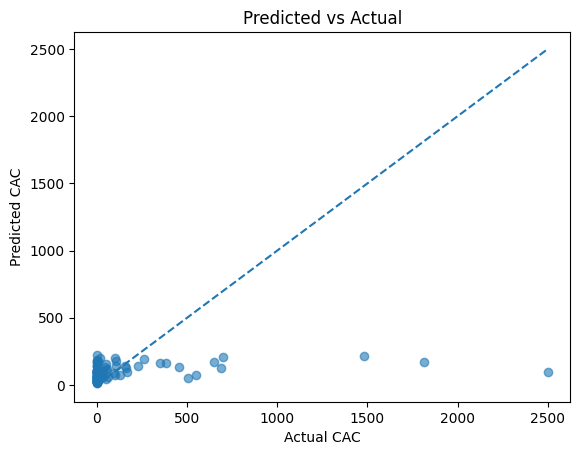

In [ ]:

plt.scatter(yte_cont, y_hat, alpha=0.6)
plt.plot([0, yte_cont.max()],[0, yte_cont.max()], ls="--")
plt.xlabel("Actual CAC"); plt.ylabel("Predicted CAC"); plt.title("Predicted vs Actual"); plt.show()


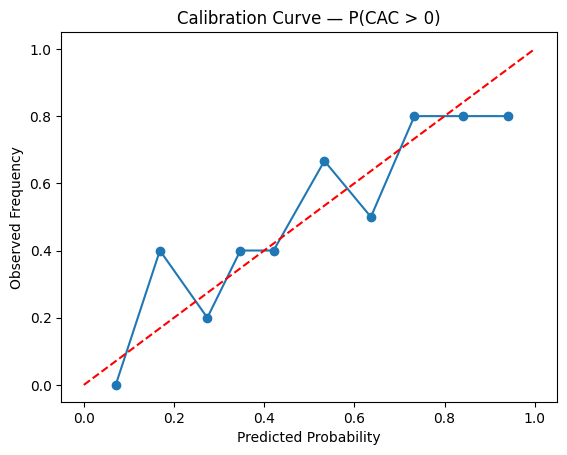

In [123]:
from sklearn.calibration import calibration_curve
frac_pos, mean_pred = calibration_curve((y_te_raw>0).astype(int), p_hat_te, n_bins=10, strategy="quantile")
plt.plot(mean_pred, frac_pos, "o-")
plt.plot([0,1],[0,1],"r--")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve — P(CAC > 0)")
plt.show()
